# Load Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'figure.figsize':(11,7), 'figure.dpi':120})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']

In [2]:
startTime = time.time()

In [3]:
#filename = '../../002_Data/Release_4/cox_time_ready_last_data.pickle'
filename = '../../002_Data/Release_4/cox_time_ready.pickle'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()
df.head()

,PAST_DUE,TOTAL_60_DAYS_AMT,NUM_PREM_FOR_PER,BREAK_ARRANGEMENT,COVID_REMINDER,MULTI_DWELL_SIZE,SNAP_GEO,NUM_PER_FOR_PREM,HAS_COTENANT,SPA_PER_ID,CMIS_MATCH,start,stop
0,0,0.00,1,0,0,0,0.167376,2,True,1,False,59,60
2,0,0.00,1,0,0,0,0.000000,1,False,3,False,0,60
14,0,119.05,1,0,0,0,0.000000,1,False,3,False,12,13
27,0,4.42,1,0,0,0,0.000000,1,False,3,False,25,26
63,0,0.00,1,0,0,0,0.259762,2,True,4,False,25,60


In [4]:
df.columns.to_list()

['PAST_DUE',
 'TOTAL_60_DAYS_AMT',
 'NUM_PREM_FOR_PER',
 'BREAK_ARRANGEMENT',
 'COVID_REMINDER',
 'MULTI_DWELL_SIZE',
 'SNAP_GEO',
 'NUM_PER_FOR_PREM',
 'HAS_COTENANT',
 'SPA_PER_ID',
 'CMIS_MATCH',
 'start',
 'stop']

# Setup

In [5]:
from lifelines import CoxTimeVaryingFitter
from custom_methods import model_eval
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

id_col = 'SPA_PER_ID'
event_col = 'CMIS_MATCH'
#event_col = 'LAST_MO_W_DATA'
start_col = 'start'
stop_col = 'stop'
model = CoxTimeVaryingFitter()
cutoffs = [0.0001, 0.0005, 0.001, 0.005]
scaler = None
sampler = None
#scaler = StandardScaler()
#sampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Run on All Data

In [6]:
model_all = CoxTimeVaryingFitter()

model_all = model_all.fit(
    df=df, 
    event_col=event_col, 
    start_col=start_col, 
    stop_col=stop_col, 
    id_col=id_col,
    step_size=0.1
)

In [7]:
model_all.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 632511 periods, 85494 subjects, 5028 events>
         event col = 'CMIS_MATCH'
number of subjects = 85494
 number of periods = 632511
  number of events = 5028
partial log-likelihood = -50124.58
  time fit was run = 2021-06-01 01:34:15 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
PAST_DUE            0.33       1.39       0.00             0.32             0.34                 1.38                 1.40
TOTAL_60_DAYS_AMT   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
NUM_PREM_FOR_PER    2.78      16.16       0.06             2.66             2.91                14.24                18.34
BREAK_ARRANGEMENT   0.41       1.51       0.05             0.32             0.50                 1.38                 1.66
COVID_REMINDER      0.29       1.33       0.01             0.26             0.31                 1.30                 1.36
MULTI_DWELL_SIZE    0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
SNAP_GEO            0.24       1.27       0.09             0.07             0.41                 1.07                 1.50
NUM_PER_FOR_PREM    0.26       1.30       0.02             0.22             0.31                 1.24                 1.37
HAS_COTENANT       -0.45       0.64       0.03            -0.51            -0.39                 0.60                 0.68

                       z      p   -log2(p)
covariate                                 
PAST_DUE           91.50 <0.005        inf
TOTAL_60_DAYS_AMT  54.57 <0.005        inf
NUM_PREM_FOR_PER   43.08 <0.005        inf
BREAK_ARRANGEMENT   8.97 <0.005      61.51
COVID_REMINDER     24.15 <0.005     425.58
MULTI_DWELL_SIZE    7.95 <0.005      48.94
SNAP_GEO            2.78   0.01       7.51
NUM_PER_FOR_PREM   10.87 <0.005      89.07
HAS_COTENANT      -13.65 <0.005     138.55
---
Partial AIC = 100267.15
log-likelihood ratio test = 10374.65 on 9 df
-log2(p) of ll-ratio test = inf

In [8]:
print(
    model_all.summary[["coef", "exp(coef)", "p", 'exp(coef) lower 95%', 'exp(coef) upper 95%']].\
    rename({'exp(coef) lower 95%':'[0.025', 'exp(coef) upper 95%':'0.975]'}, axis=1).\
    to_latex(float_format='%.3f')
)

\begin{tabular}{lrrrrr}
\toprule
{} &   coef &  exp(coef) &     p &  [0.025 &  0.975] \\
covariate         &        &            &       &         &         \\
\midrule
PAST\_DUE          &  0.332 &      1.393 & 0.000 &   1.383 &   1.403 \\
TOTAL\_60\_DAYS\_AMT &  0.001 &      1.001 & 0.000 &   1.001 &   1.001 \\
NUM\_PREM\_FOR\_PER  &  2.783 &     16.160 & 0.000 &  14.239 &  18.341 \\
BREAK\_ARRANGEMENT &  0.414 &      1.513 & 0.000 &   1.382 &   1.656 \\
COVID\_REMINDER    &  0.287 &      1.333 & 0.000 &   1.302 &   1.364 \\
MULTI\_DWELL\_SIZE  &  0.008 &      1.008 & 0.000 &   1.006 &   1.010 \\
SNAP\_GEO          &  0.239 &      1.270 & 0.005 &   1.073 &   1.503 \\
NUM\_PER\_FOR\_PREM  &  0.264 &      1.302 & 0.000 &   1.242 &   1.366 \\
HAS\_COTENANT      & -0.450 &      0.638 & 0.000 &   0.598 &   0.680 \\
\bottomrule
\end{tabular}



In [9]:
model_all.AIC_partial_

100267.15075286604

## Plot Cumulative Hazard

In [10]:
def coxTVC_predict_cumulative_hazard(baseline: pd.Series, partials: pd.Series) -> pd.DataFrame:
    return pd.DataFrame(np.outer(baseline, partials))

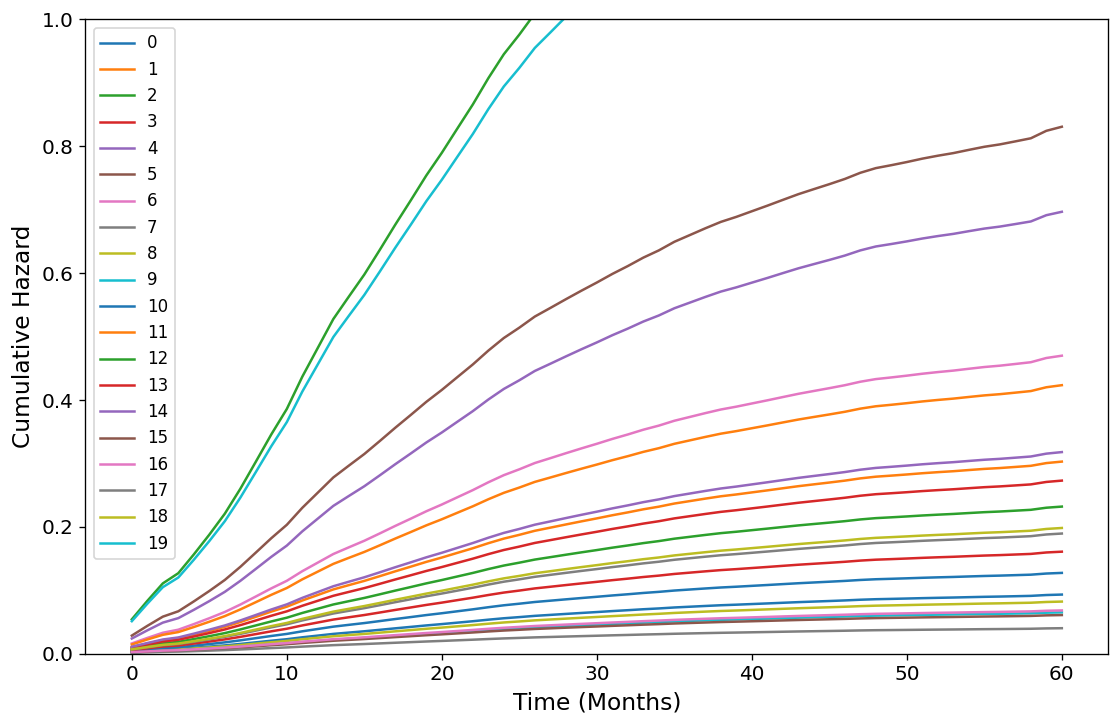

In [11]:
n = 20
ylim = (0, 1)

pos_sample = df[df[event_col]].sample(n)

coxTVC_predict_cumulative_hazard(
    baseline = model_all.baseline_cumulative_hazard_, 
    partials = model_all.predict_partial_hazard(pos_sample.drop(event_col, axis=1))
).plot()

plt.xlabel('Time (Months)', fontsize=fontsize)
plt.xticks(fontsize=fontsize-2)
plt.ylabel('Cumulative Hazard', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.ylim(ylim)
plt.savefig(fname=image_dest+'coxTVC_hazard_P.png', bbox_inches='tight')
plt.show();

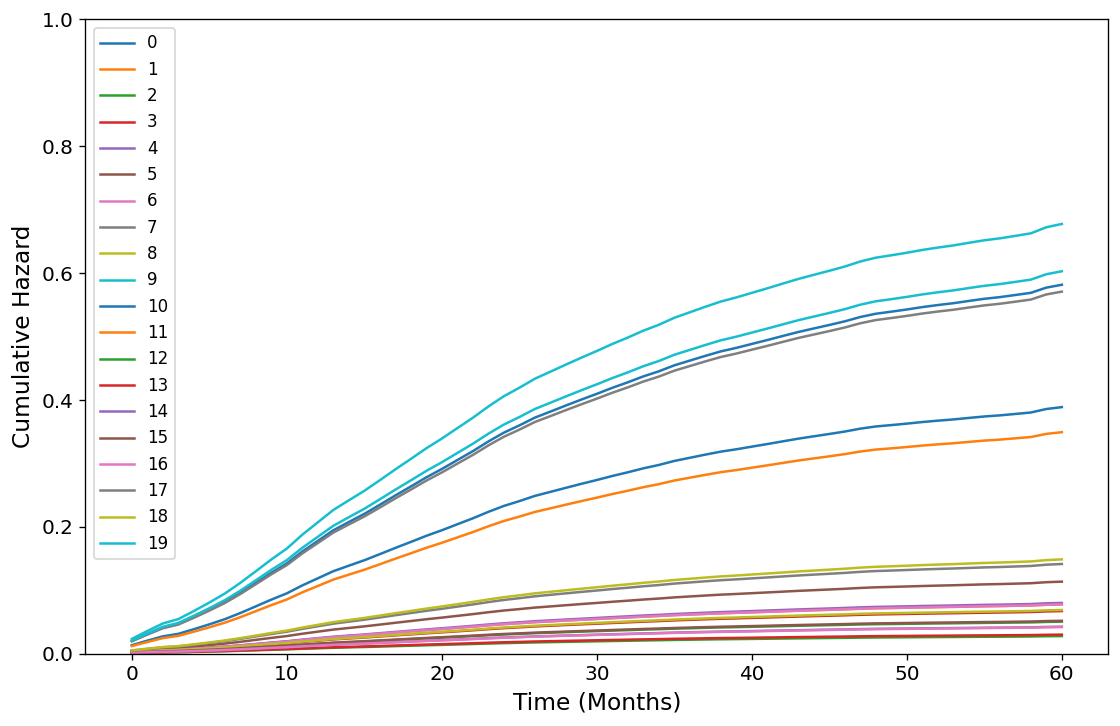

In [12]:
neg_sample = df[~df[event_col]].sample(n)

coxTVC_predict_cumulative_hazard(
    baseline = model_all.baseline_cumulative_hazard_, 
    partials = model_all.predict_partial_hazard(neg_sample.drop(event_col, axis=1))
).plot()

plt.xlabel('Time (Months)', fontsize=fontsize)
plt.xticks(fontsize=fontsize-2)
plt.ylabel('Cumulative Hazard', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.ylim(ylim)
plt.savefig(fname=image_dest+'coxTVC_hazard_N.png', bbox_inches='tight')
plt.show();

# Run K-Folds

## Run

In [13]:
predictions = model_eval.k_folds(
    df = df, 
    event_col = event_col,
    id_col = id_col, 
    k = 4, 
    model = model, 
    scaler = scaler,
    sampler = sampler
)

# To get single prediciton for each person, take max risk prediction
#predictions = predictions.groupby([id_col, event_col]).prediction.max().reset_index()
#predictions.head()

In [14]:

filename = '../../002_Data/Release_4/coxTVC_predictions0.pickle'
outfile = open(filename, 'wb')
pickle.dump(predictions, outfile)
outfile.close()


## Summary

In [18]:
def find_recall_val(df:pd.DataFrame, recall_threshold:float, event_col:str='CMIS_MATCH'):
    '''
    05/25/21
    '''
    columns = ['Threshold_Value', 'Number Predicted', 'Actual Number', 'False P/N Rate', 'Precision', 'Recall', 'f-1', 'Custom']
    idx = pd.MultiIndex.from_product([['Precision', 'Recall', 'f-1', 'Custom'], ['Positive', 'Negative']], names=['Max_Of', 'Case'])
    summary = pd.DataFrame(index=idx, columns=columns)

    sorted_predictions = predictions.sort_values(by='prediction')
    for threshold in sorted_predictions['prediction']:
        binned_predictions = (df['prediction'] > threshold)
        current_summary = model_eval.evaluate_model(binned_predictions=binned_predictions, actuals=df[event_col].astype('bool'))
        if not (current_summary is None):
            '''
            for metric in summary.index.get_level_values('Max_Of').unique():
                if (summary.loc[(metric, 'Positive'), metric] < current_summary.loc['Positive', metric]) or np.isnan(summary.loc[(metric, 'Positive'), metric]):
                    summary.loc[(metric, 'Positive'), 'Number Predicted':'Custom'] = current_summary.loc['Positive']
                    summary.loc[(metric, 'Negative'), 'Number Predicted':'Custom'] = current_summary.loc['Negative']
                    summary.loc[metric, 'Threshold_Value'] = threshold
            if current_summary.loc['Positive', 'Recall'] < recall_threshold:
                summary.loc[('Recall', 'Positive'), 'Number Predicted':'Custom'] = current_summary.loc['Positive']
                summary.loc[('Recall', 'Negative'), 'Number Predicted':'Custom'] = current_summary.loc['Negative']
                summary.loc['Recall', 'Threshold_Value'] = threshold
                return summary
            '''
            if current_summary.loc['Positive', 'Recall'] < recall_threshold:
                return current_summary
    int_cols = ['Number Predicted', 'Actual Number']
    float_cols = ['Threshold_Value', 'False P/N Rate', 'Precision', 'Recall', 'f-1', 'Custom']
    for col in int_cols:
        summary[col] = summary[col].astype('int')
    for col in float_cols:
        summary[col] = summary[col].astype('float')
    return summary

In [23]:
summary_recall0 = find_recall_val(predictions, recall_threshold=0.92)
summary_recall0

,Number Predicted,Actual Number,False P/N Rate,Precision,Recall,f-1,Custom
Case,,,,,,,
Positive,56323,302,0.657879,0.004918,0.917219,0.009784,0.461068
Negative,29171,85192,0.082781,0.999143,0.342121,0.509710,0.670632


In [24]:
summary_recall = summary_recall0.copy()

In [25]:
summary_recall['Actual Number'] = (summary_recall['Number Predicted'] * summary_recall['Precision']).astype('int')
summary_recall = summary_recall.drop('Custom', axis=1).rename(
    {'Number Predicted':'Predicted', 'Actual Number':'Hits', 'False P/N Rate':'False P/N'}, axis=1)
summary_recall.index.names = ['Class']

to_change = ['False P/N', 'Precision', 'Recall', 'f-1']
for i in to_change:
    summary_recall[i] = summary_recall[i].astype('float')

print(summary_recall.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Predicted &   Hits &  False P/N &  Precision &  Recall &  f-1 \\
Class    &            &        &            &            &         &      \\
\midrule
Positive &      56323 &    277 &       0.66 &       0.00 &    0.92 & 0.01 \\
Negative &      29171 &  29146 &       0.08 &       1.00 &    0.34 & 0.51 \\
\bottomrule
\end{tabular}



In [15]:
summary = model_eval.get_summary(predictions)
summary

Threshold_Value  Number Predicted  Actual Number  \
Max_Of    Case                                                         
Precision Positive     7,228.695906                 3            302   
          Negative     7,228.695906             85491          85192   
Recall    Positive         0.220236             85433            302   
          Negative         0.220236                61          85192   
f-1       Positive        26.609771               543            302   
          Negative        26.609771             84951          85192   
Custom    Positive         0.227765             84283            302   
          Negative         0.227765              1211          85192   

                    False P/N Rate  Precision   Recall      f-1   Custom  
Max_Of    Case                                                            
Precision Positive        0.000023   0.333333 0.003311 0.006557 0.168322  
          Negative        0.996689   0.996479 0.999977 0.998225 0.998228  
Recall    Positive        0.999296   0.003523 0.996689 0.007022 0.500106  
          Negative        0.003311   0.983607 0.000704 0.001408 0.492155  
f-1       Positive        0.006080   0.046041 0.082781 0.059172 0.064411  
          Negative        0.917219   0.996739 0.993920 0.995327 0.995329  
Custom    Positive        0.985797   0.003571 0.996689 0.007117 0.500130  
          Negative        0.003311   0.999174 0.014203 0.028008 0.506689

In [17]:
'''
k, precision, f-1
2, 0.222222, 0.058577
3, 0.250000, 0.056112
4, 0.250000, 0.061350
4, 0.300000, 0.058366
5, 0.200000, 0.055888
'''

'\nk, precision, f-1\n2, 0.222222, 0.058577\n3, 0.250000, 0.056112\n4, 0.250000, 0.061350\n4, 0.300000, 0.058366\n5, 0.200000, 0.055888\n'

In [18]:
model_eval.print_summary(summary)

\begin{tabular}{llrrrrrrr}
\toprule
       &   &  Predicted &   Hits &  False P/N &  Precision &  Recall &  f-1 &  Custom \\
Max\_Of & Class &            &        &            &            &         &      &         \\
\midrule
Precision & P &          3 &      1 &       0.00 &       0.33 &    0.00 & 0.01 &    0.17 \\
       & N &      85491 &  85190 &       1.00 &       1.00 &    1.00 & 1.00 &    1.00 \\
Recall & P &      85433 &    301 &       1.00 &       0.00 &    1.00 & 0.01 &    0.50 \\
       & N &         61 &     60 &       0.00 &       0.98 &    0.00 & 0.00 &    0.49 \\
f-1 & P &        543 &     25 &       0.01 &       0.05 &    0.08 & 0.06 &    0.06 \\
       & N &      84951 &  84674 &       0.92 &       1.00 &    0.99 & 1.00 &    1.00 \\
Custom & P &      84283 &    301 &       0.99 &       0.00 &    1.00 & 0.01 &    0.50 \\
       & N &       1211 &   1210 &       0.00 &       1.00 &    0.01 & 0.03 &    0.51 \\
\bottomrule
\end{tabular}



# Print Time

In [19]:
from custom_methods.calc_time import calc_time_from_sec

calc_time_from_sec(time.time()-startTime)

hours:minutes:seconds = 0:12:54.91049838066101
